# Generate Order History by Customer and Product Categories for PCA and Customer Segmentation Analysis
This notebook
- imports all Instacart data from PostgreSQL (User needs to store login and password in `config.py` in the same folder where this notebook is running)
- uses `merge` and `crosstab` function to generate order history data for analysis
- summarizes customers' order history by `aisle`, `department`, a new organic category and total # of orders
  * there are over 49,600 products, too many dimensions for customer segmentation
  * `aisle` and `department` both represents product categories, the latter is broader. The data set has 134 `aisles` and 21 `departments`
  * a new category on organic food is added for any product name with the word 'organic'
  * the resulting purchase history will be double-counting because number of purchases are summed by both `aisles` and `departments`
- selects approximately 20,000 customer data as training set for PCA and unsupervised training
- uses RobustScaler to transform/scale the training set data

### Import dependecies and PostgreSQL info

In [1]:
%matplotlib inline
import pandas as pd
from sqlalchemy import create_engine
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3)

# postgres login credentials and DB location
from config import pg_user, pg_pw
db_loc = 'localhost:5432'
db_name = 'p3_instacart'
engine = create_engine(f"postgresql+psycopg2://{pg_user}:{pg_pw}@{db_loc}/{db_name}")
connection = engine.connect()

### Import data to dataframes using Pandas

In [2]:
aisles = pd.read_sql("SELECT * FROM aisles", connection)
departments = pd.read_sql("SELECT * FROM departments", connection)
products = pd.read_sql("SELECT * FROM products", connection)
orders = pd.read_sql("SELECT * FROM orders", connection)
order_products = pd.read_sql("SELECT * FROM order_products", connection)

### Merge products with aisle and department data frames

In [3]:
# Joining products with aisle and department df
products_merge = products.merge(aisles, how='left', on='aisle_id').merge(departments, how='left', on='department_id')
products_merge.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


##### Add `organic` category
- The `aisle` and `department` attributes do not differentiate between organic and non-organic products. It was decided to add an `organic` category and apply to any product with organic in `product_name`

In [4]:
products_merge['organic'] = products_merge['product_name'].apply(lambda x: 'organic' if 'Organic' in x else 'non-organic')

##### Count number of aisles, departments and organic products

In [5]:
print(f'There are {len(products_merge["aisle"].unique())} unique aisles,',
      f'{len(products_merge["department"].unique())} departments.',
      f'{len(products_merge[products_merge["organic"]=="organic"]):,} out of {len(products_merge["product_id"].unique()):,} are organic products')

There are 134 unique aisles, 21 departments. 5,035 out of 49,688 are organic products


### Merge data frames to form order history

In [6]:
# Joining orders with order_products and products_merge
orders_history = orders.merge(order_products, on='order_id').merge(products_merge, on='product_id').sort_values(by='order_id')

# Example for `Order_id` = 1
orders_history[orders_history['order_id']==1]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,organic
23218323,1,112108,train,4,4,10,9.0,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs,organic
13576120,1,112108,train,4,4,10,9.0,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce,organic
32575950,1,112108,train,4,4,10,9.0,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods,non-organic
4129259,1,112108,train,4,4,10,9.0,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce,non-organic
2346045,1,112108,train,4,4,10,9.0,47209,7,0,Organic Hass Avocado,24,4,fresh fruits,produce,organic
281612,1,112108,train,4,4,10,9.0,13176,6,0,Bag of Organic Bananas,24,4,fresh fruits,produce,organic
32723104,1,112108,train,4,4,10,9.0,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs,non-organic
4262054,1,112108,train,4,4,10,9.0,22035,8,1,Organic Whole String Cheese,21,16,packaged cheese,dairy eggs,organic


`Order_ID` 1
- Bought by `user_id` 112108
- Has 8 items, half of them were first-time order
- Items include organic vegetables and cheese

### Sum Order History for Each Customer by Aisle, Department and Organic
- First, generates pivot tables summing the each customer's purchases by `aisle`, `department` and `organic`, respectively
- Second, a `Total` column added to sum total number of products purchased by customer (without double-counting)
- Third, concatenate the 3 pivot tables together

In [7]:
# 1) Order by aisle
orders_user_aisle = pd.crosstab(index=orders_history['user_id'], columns=orders_history['aisle'])
orders_user_aisle['Total'] = orders_user_aisle.sum(axis=1)
# show User ID 1 to 3
orders_user_aisle.head(3)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,Total
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,70
2,0,3,0,0,0,0,2,0,0,0,...,1,1,0,0,0,0,2,0,42,226
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,88


In [8]:
#2) Order by department
orders_user_dept = pd.crosstab(index=orders_history['user_id'], columns=orders_history['department'])
# show User ID 1 to 3
orders_user_dept.head(3)

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,15,4,0,0,17,0,0,...,3,0,0,0,0,1,0,0,5,25
2,0,0,2,9,3,0,4,49,24,0,...,0,3,1,0,0,11,2,0,43,47
3,0,0,0,3,0,0,0,21,2,4,...,1,0,0,0,0,4,0,0,38,9


In [9]:
#3) Order by organic food
orders_user_organic = pd.crosstab(index=orders_history['user_id'], columns=orders_history['organic'])
orders_user_organic.drop(columns=['non-organic'], inplace=True)
# show User ID 1 to 3
orders_user_organic.head(3)

organic,organic
user_id,
1,18
2,56
3,30


##### Merge the 3 crosstabs

In [10]:
order_history = orders_user_aisle.merge(
    orders_user_dept, left_index=True, right_index=True, how='outer').merge(
    orders_user_organic, left_index=True, right_index=True, how='outer', suffixes=('','_d'))
order_history.head()

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,international,meat seafood,missing_y,other_y,pantry,personal care,pets,produce,snacks,organic
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,5,25,18
2,0,3,0,0,0,0,2,0,0,0,...,3,1,0,0,11,2,0,43,47,56
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,0,0,38,9,30
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1,2
5,1,4,0,0,0,0,0,0,0,0,...,4,0,0,0,3,0,0,23,1,23


In [11]:
# export order history to csv
order_history.to_csv('../Outputs/customer_order_history.csv')

### Explore Customer Order Data

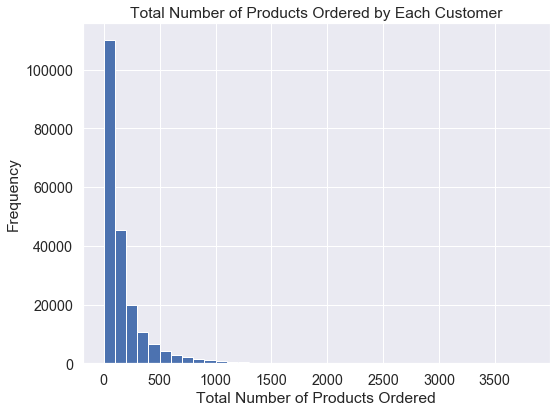

In [12]:
# Plot histogram for total # of products by customer
plt.figure(figsize=(8,6))
order_history['Total'].plot(kind='hist', bins=range(0,max(order_history['Total'])+100, 100))
plt.title('Total Number of Products Ordered by Each Customer')
plt.xlabel('Total Number of Products Ordered')
plt.tight_layout()
plt.savefig('../Outputs/customer_order_freq.png')
plt.show()

In [13]:
order_history['Total'].describe()

count    206209.000000
mean        164.004025
std         206.014923
min           3.000000
25%          44.000000
50%          90.000000
75%         196.000000
max        3725.000000
Name: Total, dtype: float64

In [14]:
print(f'There are {len(orders["user_id"].unique()):,} users in orders table. {len(orders_user_aisle[orders_user_aisle["Total"] >= 100]):,} of them ordered more than 100 items')

There are 206,209 users in orders table. 96,040 of them ordered more than 100 items


### Create Training Set
- There are 206,209 unique customers in the dataset, majority of them bought less than 100 items
- Randomly select approximately 20,000 customers with over 100 ordered items as training set

In [15]:
# use sklearn train_test_split module to select 
from sklearn.model_selection import train_test_split

# Original Aisle Set
cust_train, Cust_test = train_test_split(order_history[order_history['Total'] >= 100], train_size=0.21, random_state=42)
cust_train

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,international,meat seafood,missing_y,other_y,pantry,personal care,pets,produce,snacks,organic
user_id,,,,,,,,,,,,,,,,,,,,,
19510,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,5,15,0,76,14,152
147319,0,1,0,0,0,1,1,2,0,0,...,3,3,1,0,7,0,0,18,6,23
85028,0,8,0,3,126,0,1,0,0,0,...,11,12,0,1,47,0,0,173,49,68
72168,0,0,0,0,0,0,4,0,0,0,...,2,2,0,0,13,3,0,43,31,93
142535,0,1,0,0,0,0,1,0,0,0,...,3,6,0,0,8,4,0,12,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13607,0,0,0,0,19,0,1,0,0,0,...,2,16,1,0,9,3,0,398,67,519
117498,0,0,0,0,0,0,0,0,0,0,...,0,1,9,0,11,3,1,25,6,60
164881,0,1,0,0,0,0,6,0,0,0,...,1,1,0,0,12,1,0,33,6,11


In [16]:
# Export to CSV
cust_train.to_csv('../Outputs/customer_order_train.csv')

### Transform/Scale Data using RobustScaler

In [17]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

##### Transform training set

In [18]:
rs = scaler.fit(cust_train)
cust_train_rescaled = rs.transform(cust_train)
df_cust_train_rs = pd.DataFrame(cust_train_rescaled, columns=order_history.columns)
df_cust_train_rs.set_index(cust_train.index, inplace=True)
df_cust_train_rs.head()

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,international,meat seafood,missing_y,other_y,pantry,personal care,pets,produce,snacks,organic
user_id,,,,,,,,,,,,,,,,,,,,,
19510,0.0,0.0,0.0,0.0,0.0,0.0,-0.25,0.0,0.0,0.0,...,-0.333333,-0.250,0.0,0.0,-0.466667,3.50,0.0,0.202532,-0.04,0.929293
147319,0.0,0.5,0.0,0.0,0.0,1.0,0.00,2.0,0.0,0.0,...,0.666667,0.000,1.0,0.0,-0.333333,-0.25,0.0,-0.531646,-0.36,-0.373737
85028,0.0,4.0,0.0,3.0,126.0,0.0,0.00,0.0,0.0,0.0,...,3.333333,1.125,0.0,1.0,2.333333,-0.25,0.0,1.430380,1.36,0.080808
72168,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0.0,...,0.333333,-0.125,0.0,0.0,0.066667,0.50,0.0,-0.215190,0.64,0.333333
142535,0.0,0.5,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.666667,0.375,0.0,0.0,-0.266667,0.75,0.0,-0.607595,-0.40,-0.595960


In [19]:
# save to csv
df_cust_train_rs.to_csv('../Outputs/customer_order_train_rescale.csv')

##### transform entire order history as well

In [20]:
cust_order_rescaled = rs.transform(order_history)
df_cust_order_rs = pd.DataFrame(cust_order_rescaled, columns=order_history.columns)
df_cust_order_rs.set_index(order_history.index, inplace=True)
df_cust_order_rs.head()

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,international,meat seafood,missing_y,other_y,pantry,personal care,pets,produce,snacks,organic
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,-0.25,0.0,0.0,0.0,...,-0.333333,-0.375,0.0,0.0,-0.733333,-0.25,0.0,-0.696203,0.40,-0.424242
2,0.0,1.5,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,...,0.666667,-0.250,0.0,0.0,-0.066667,0.25,0.0,-0.215190,1.28,-0.040404
3,0.0,0.0,0.0,0.0,0.0,0.0,-0.25,0.0,0.0,0.0,...,-0.333333,-0.375,0.0,0.0,-0.533333,-0.25,0.0,-0.278481,-0.24,-0.303030
4,0.0,0.0,0.0,0.0,0.0,0.0,-0.25,0.0,0.0,0.0,...,-0.333333,-0.375,0.0,0.0,-0.800000,-0.25,0.0,-0.734177,-0.56,-0.585859
5,1.0,2.0,0.0,0.0,0.0,0.0,-0.25,0.0,0.0,0.0,...,1.000000,-0.375,0.0,0.0,-0.600000,-0.25,0.0,-0.468354,-0.56,-0.373737


In [21]:
df_cust_order_rs.to_csv('../Outputs/customer_order_rescale.csv')